## Modeling transpiration rates in eucalyptus trees using machine learning

Morgan Tholl,
Portland State University

Data source: Dr. Edoardo Daly & Alberto Manarte Lopes Peixoto Neto, Monash University

## Sanitizing and Manipulating Data

In [1]:
## Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [40]:
## Import data and sanitize ##

# Import data
# Meteorological data
def sanitize_weather(row):
    if all([row[0],row[1],row[2],row[3],row[4]]): #can insert more data sanitizing conditions here
        return {str(row[0]):       # Time stamp for data matching
                [float(row[1]),    # Solar radiation, W/m^2
                float(row[2]),     # Air temp, deg C
                float(row[3]),     # Relative humidity, %
                float(row[4])]}    # Vapor pressure deficit, kPa
    else: 
        return False
    
weather = {}
import csv
with open('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\weather_30min.csv') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    next(reader)
    for row in reader:
        data=sanitize_weather(row)
        if data:  
            weather.update(data)
            
            
# Rainfall data
rainfall = {}
import csv
with open('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\daily_rain.csv') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    next(reader)
    for row in reader:
        if row: 
            rainfall.update({str(row[0]): float(row[1])})  #daily rainfall in mm


# Import soil data here using global averages between all depths, all locations
soil_xls = pd.ExcelFile('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\Plantation soil moisture.xls')
soil_data = pd.read_excel(soil_xls,'Averages')
soil_keys = soil_data['Date Time'].to_list()
soil_values = soil_data['Global'].to_list()
soil_dict = {}
for s, date in enumerate(soil_keys):
    soil_dict.update({str(date) : float(soil_values[s])})

    
# Add groundwater level data
# Use 3663 for 17-18
GWL_xls = pd.ExcelFile('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\groundwater level.xls')
gwl = pd.read_excel(GWL_xls,'3663')
gwl_keys = gwl['datetime'].to_list()
gwl_values = gwl['waterlevel_corr'].to_list()
gwl_1718 = {}
for h, date in enumerate(gwl_keys):
    gwl_1718.update({str(date) : float(gwl_values[h])})

# Use 3666 for 19-20
GWL_xls = pd.ExcelFile('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\groundwater level.xls')
gwl = pd.read_excel(GWL_xls,'3666')
gwl_keys = gwl['datetime'].to_list()
gwl_values = gwl['waterlevel_corr'].to_list()
gwl_1920 = {}
for h, date in enumerate(gwl_keys):
    gwl_1920.update({str(date) : float(gwl_values[h])})
    
gwl_full = {**gwl_1718, **gwl_1920}

    
# Transpiration data (based on sap flux measurements)
transpiration_1718 = []
transpiration_1920 = []
import csv
with open('C:\\Users\\morga\\CE510 Ecohydrology\\Eucalyptus_ML\\avg_transp.csv') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    next(reader)
    for row in reader:
        if row[1]:
            transpiration_1718.append([str(row[0]),float(row[1])])
        if row[2]:
            transpiration_1920.append([str(row[0]),float(row[2])])

transpiration = transpiration_1718 + transpiration_1920

In [57]:
# Store available data into X and Y matrices
X = []
Y = []
timestamp_full = []
for row in transpiration:
    date = row[0]
    x = []
    x1 = weather.get(date,'missing') #search weather dictionary for time stamp - if missing return False
    x2 = rainfall.get(date[:10],'missing') #same for rainfall dictionary
    x3 = gwl_full.get(date,'missing')
    if x1 != 'missing' and x2 != 'missing' and x3 != 'missing':
        x.extend(x1)
        x.append(x2)
        x.append(x3)
        X.append(x)
        Y.append(row[1])
        timestamp_full.append(date)


# "X": R [W/m^2], Temp [deg C], RH [%], VPD [kPa], rainfall [mm/d]
# "Y": target transpiration [mm/d]
X = np.array(X)
Y = np.array(Y) * 86400 # conversion factor to [mm/d]

# Create X and Y matrices for separating '17-'18 data
X_1718 = []
Y_1718 = []
timestamp_1718 = []
for row in transpiration_1718:
    date = row[0]
    x = []
    x1 = weather.get(date,'missing') #search weather dictionary for time stamp - if missing return False
    x2 = rainfall.get(date[:10],'missing') #same for rainfall dictionary
    x3 = gwl_1718.get(date,'missing')
    if x1 != 'missing' and x2 != 'missing' and x3 != 'missing':
        x.extend(x1)
        x.append(x2)
        x.append(x3)
        X_1718.append(x)
        Y_1718.append(row[1])
        timestamp_1718.append(date)

# "X": R [W/m^2], Temp [deg C], RH [%], VPD [kPa], rainfall [mm/d]
# "Y": target transpiration [mm/d]
X_1718 = np.array(X_1718)
Y_1718 = np.array(Y_1718) * 86400 # conversion factor to [mm/d]

# Create X and Y matrices for separating '19-'20 data
X_1920 = []
Y_1920 = []
timestamp_1920 = []
for row in transpiration_1920:
    date = row[0]
    x = []
    x1 = weather.get(date,'missing') #search weather dictionary for time stamp - if missing return False
    x2 = rainfall.get(date[:10],'missing') #same for rainfall dictionary
    x3 = soil_dict.get(date,'missing') #add in soil moisture for '19-'20 data
    #x4 = gwl_1920.get(date,'missing')
    if x1 != 'missing' and x2 != 'missing' and x3 != 'missing':
        x.extend(x1)
        x.append(x2)
        x.append(x3)
        #x.append(x4)
        X_1920.append(x)
        Y_1920.append(row[1])
        timestamp_1920.append(date)

# "X": R [W/m^2], Temp [deg C], RH [%], VPD [kPa], rainfall [mm/d], soil moisture [units?]
# "Y": target transpiration [mm/d]
X_1920 = np.array(X_1920)
Y_1920 = np.array(Y_1920) * 86400 # conversion factor to [mm/d]

print(f"Mean transpiration for '19-'20 data is {round(np.mean(Y_1920),4)} mm/d")
print(f"Mean transpiration for '17-'18 data is {round(np.mean(Y_1718),4)} mm/d")
print(f"Mean overall transpiration is {round(np.mean(Y),4)} mm/d")
print('\nStandard deviations:')
print(np.std(Y_1920))
print(np.std(Y_1718))
print(np.std(Y))

Mean transpiration for '19-'20 data is 1.1092 mm/d
Mean transpiration for '17-'18 data is 1.6647 mm/d
Mean overall transpiration is 1.3937 mm/d

Standard deviations:
0.7845016861044073
1.411866848524432
1.159720856022029


In [82]:
## Standardize and split data ##

#Set aside testing and validation sets: 80% training, 10% testing, 10% validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

#Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X = scaler.transform(X)

#Define m and n using input features
m = len(Y_train)
n = len(X_train[0]) +1
print("m = ", m, "for combined data")
print("n = ", n)

#Repeat for separate '17-'18 and '19-'20 data
from sklearn.model_selection import train_test_split
X_train_1718, X_test_1718, Y_train_1718, Y_test_1718 = train_test_split(X_1718, Y_1718, test_size = 0.2, random_state = 42)
X_test_1718, X_val_1718, Y_test_1718, Y_val_1718 = train_test_split(X_test_1718, Y_test_1718, test_size = 0.5, random_state = 42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_1718 = scaler.fit_transform(X_train_1718)
X_test_1718 = scaler.transform(X_test_1718)
X_val_1718 = scaler.transform(X_val_1718)
X_1718 = scaler.transform(X_1718)

m = len(Y_train_1718)
n = len(X_train_1718[0]) +1
print("m = ", m, "for '17-'18 data")

from sklearn.model_selection import train_test_split
X_train_1920, X_test_1920, Y_train_1920, Y_test_1920 = train_test_split(X_1920, Y_1920, test_size = 0.2, random_state = 42)
X_test_1920, X_val_1920, Y_test_1920, Y_val_1920 = train_test_split(X_test_1920, Y_test_1920, test_size = 0.5, random_state = 42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_1920 = scaler.fit_transform(X_train_1920)
X_test_1920 = scaler.transform(X_test_1920)
X_val_1920 = scaler.transform(X_val_1920)
X_1920 = scaler.transform(X_1920)

m = len(Y_train_1920)
n = len(X_train_1920[0]) +1
print("m = ", m, "for '19-'20 data")

m =  1720 for combined data
n =  7
m =  818 for '17-'18 data
m =  9006 for '19-'20 data


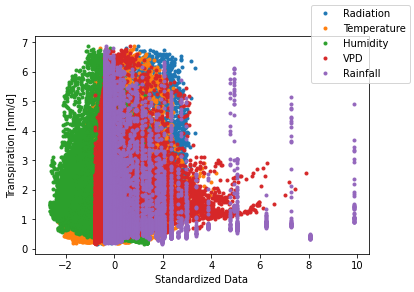

In [15]:
## Data visualization
radiation = X_train[:,0]
temperature = X_train[:,1]
humidity = X_train[:,2]
vpd = X_train[:,3]
rain = X_train[:,4]

fig, ax = plt.subplots(1,1)
ax.plot(radiation,Y_train,'.')
ax.plot(temperature,Y_train,'.')
ax.plot(humidity,Y_train,'.')
ax.plot(vpd,Y_train,'.')
ax.plot(rain,Y_train,'.')
ax.set_ylabel('Transpiration [mm/d]')
ax.set_xlabel('Standardized Data')
plt.figlegend(
    ('Radiation', 'Temperature', 'Humidity', 'VPD', 'Rainfall'))

Comment here on expected relationships between features and transpiration

## Support Vector Machine for '19-'20

In [59]:
## Implement support vector machine using a grid search on different parameters ###

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
params_ = {
    "kernel": ['rbf'], #'linear', 'poly'
    "epsilon": [0.1], #1, 5
    "C": [100] #1, 10
    #"degree": [1] #2, 3
}

svr_cv_1920 = GridSearchCV(svr, params_, verbose=1, scoring = 'r2')
svr_cv_1920.fit(X_train_1920, Y_train_1920)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=SVR(),
             param_grid={'C': [100], 'epsilon': [0.1], 'kernel': ['rbf']},
             scoring='r2', verbose=1)

In [60]:
## Model validation for support vector machine ##
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(f"Best parameters from the grid search were {svr_cv_1920.best_params_}")
print(f"R2 of training set is {svr_cv_1920.best_score_}")

Y_pred_1920 = svr_cv_1920.predict(X_test_1920)
r2_test = r2_score(Y_test_1920, Y_pred_1920)
print(f"R2 of test set is {r2_test}")

mse_test = mean_squared_error(Y_test_1920,Y_pred_1920)
print(f'MSE of test set is {mse_test}')

from sklearn.inspection import permutation_importance
res = permutation_importance(svr_cv_1920, X_train_1920, Y_train_1920, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

Best parameters from the grid search were {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
R2 of training set is 0.900137954793915
R2 of test set is 0.9108974018713384
MSE of test set is 0.05307947281745242
The permutation-based feature importance is [0.50072222 0.1311639  0.18236356 0.05352408 0.0451208  0.08710545]


Text(0, 0.5, 'Average transpiration (mm/d)')

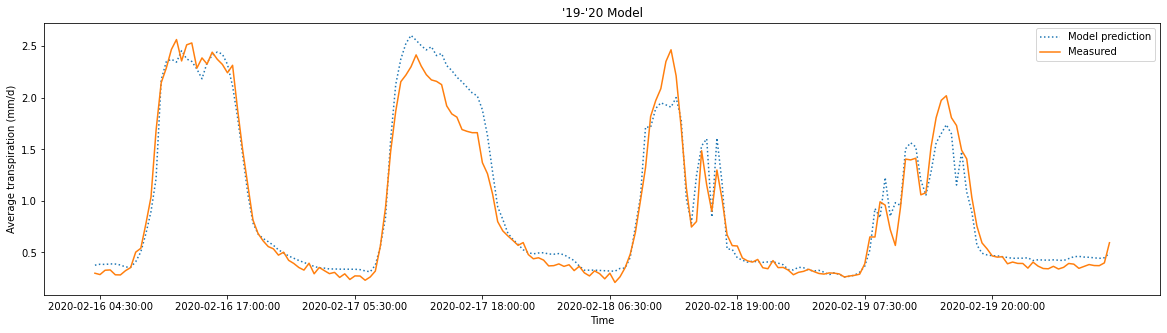

In [118]:
## Data visualization for 19-20 model

plt.figure(figsize=(20,5))
Y_pred_1920 = svr_cv_1920.predict(X_1920)
plt.plot(timestamp_1920[-200:],Y_pred_1920[-200:],linestyle='dotted',label='Model prediction')
plt.plot(timestamp_1920[-200:],Y_1920[-200:],linestyle='solid',label='Measured')
plt.xticks(np.arange(1, 200, 25))
plt.legend()
plt.title("'19-'20 Model")
plt.xlabel('Time')
plt.ylabel('Average transpiration (mm/d)')

## Support Vector Machine for '17-'18

In [75]:
svr = SVR()
params_ = {
    "kernel": ['rbf'], #'poly', 'linear'
    "epsilon": [0.1], #1, 5
    "C": [10], #1, 10
    #"degree": [6] #2, 3
}

svr_cv_1718 = GridSearchCV(svr, params_, verbose=1, scoring = 'r2')
svr_cv_1718.fit(X_train_1718, Y_train_1718)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=SVR(),
             param_grid={'C': [10], 'epsilon': [0.1], 'kernel': ['rbf']},
             scoring='r2', verbose=1)

In [79]:
print(f"Best parameters from the grid search were {svr_cv_1718.best_params_}")
print(f"R2 of training set is {svr_cv_1718.best_score_}")

Y_pred_1718 = svr_cv_1718.predict(X_test_1718)
r2_test = r2_score(Y_test_1718, Y_pred_1718)
print(f"R2 of test set is {r2_test}")

mse_test = mean_squared_error(Y_test_1718,Y_pred_1718)
print(f'MSE of test set is {mse_test}')

from sklearn.inspection import permutation_importance
res = permutation_importance(svr_cv_1718, X_train_1718, Y_train_1718, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

Best parameters from the grid search were {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
R2 of training set is 0.8920677850301264
R2 of test set is 0.9114851942293012
MSE of test set is 0.16862391775164057
The permutation-based feature importance is [0.44679908 0.03117626 0.18448631 0.0426127  0.018013   0.27691264]


Text(0, 0.5, 'Average transpiration (mm/d)')

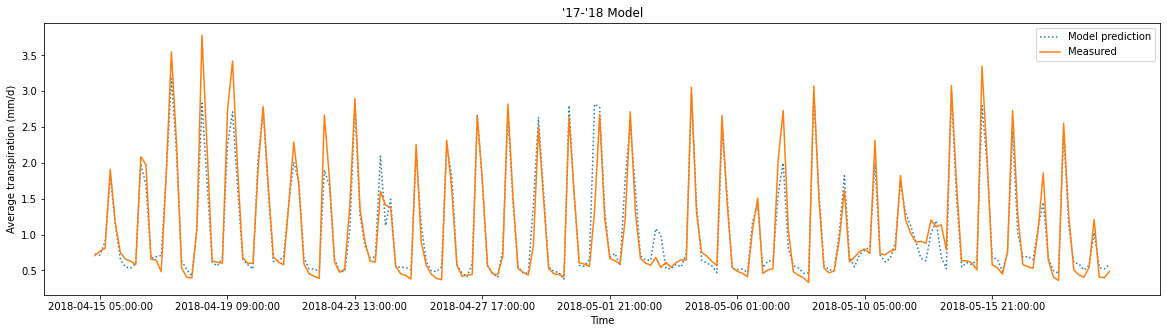

In [124]:
## Data visualization for 17-18 model

plt.figure(figsize=(20,5))
Y_pred_1718 = svr_cv_1718.predict(X_1718)
plt.plot(timestamp_1718[-200:],Y_pred_1718[-200:],linestyle='dotted',label='Model prediction')
plt.plot(timestamp_1718[-200:],Y_1718[-200:],linestyle='solid',label='Measured')
plt.xticks(np.arange(1, 200, 25))
plt.legend()
plt.title("'17-'18 Model")
plt.xlabel('Time')
plt.ylabel('Average transpiration (mm/d)')

## Combined SVM

In [55]:
svr = SVR()
params_ = {
    "kernel": ['rbf'], #'poly', 'linear'
    "epsilon": [0.1], #1, 5
    "C": [100] #1,10
    #"degree": [1, 2, 3] #2, 3
}

svr_cv = GridSearchCV(svr, params_, verbose=1, scoring = 'r2')
svr_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=SVR(),
             param_grid={'C': [100], 'epsilon': [0.1], 'kernel': ['rbf']},
             scoring='r2', verbose=1)

In [56]:
print(f"Best parameters from the grid search were {svr_cv.best_params_}")
print(f"R2 of training set is {svr_cv.best_score_}")

Y_pred = svr_cv.predict(X_test)
r2_test = r2_score(Y_test, Y_pred)
print(f"R2 of test set is {r2_test}")

mse_test = mean_squared_error(Y_test,Y_pred)
print(f'MSE of test set is {mse_test}')

from sklearn.inspection import permutation_importance
res = permutation_importance(svr_cv, X_train, Y_train, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

Best parameters from the grid search were {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
R2 of training set is 0.8443567952243967
R2 of test set is 0.8566114368885254
MSE of test set is 0.14810642257302625
The permutation-based feature importance is [0.37640298 0.09047161 0.17943769 0.0474723  0.03256692 0.2736485 ]


Text(0, 0.5, 'Average transpiration (mm/d)')

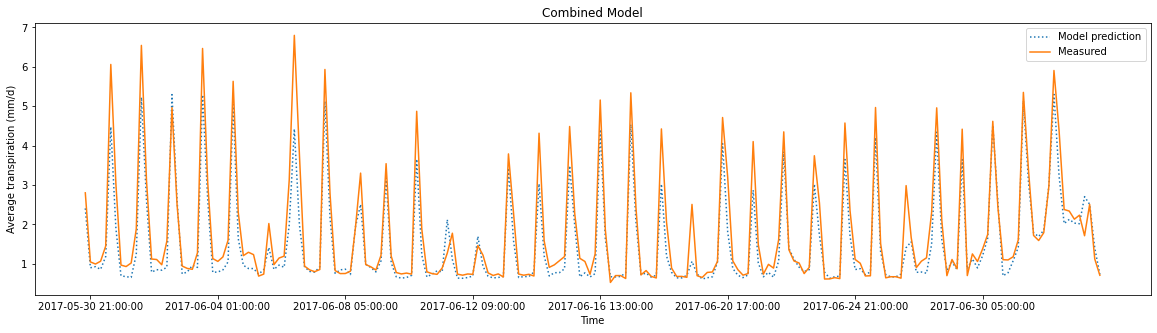

In [125]:
## Data visualization for combined model

plt.figure(figsize=(20,5))
Y_pred = svr_cv.predict(X)
plt.plot(timestamp_full[:200],Y_pred[:200],linestyle='dotted',label='Model prediction')
plt.plot(timestamp_full[:200],Y[:200],linestyle='solid',label='Measured')
plt.xticks(np.arange(1, 200, 25))
plt.legend()
plt.title("Combined Model")
plt.xlabel('Time')
plt.ylabel('Average transpiration (mm/d)')